# csaQTL GWAS Suggestive Associations

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cna, pickle, os, pp 
from matplotlib import lines
from matplotlib.patches import ConnectionPatch
from figure_functions import *

res_folder = "/data/srlab/lrumker/MCSC_Project/cna-qtl/results/"
fig_dir = "/data/srlab/lrumker/MCSC_Project/cna-qtl/figs/"

In [2]:
# Load suggestive loci
sugg_loci = pd.DataFrame({})
for celltype in ["T", "B", "NK", "Myeloid"]:
    new = pd.read_table(res_folder+"gwas_"+celltype+"/gwas_suggestive_loci.tsv")
    sugg_loci = pd.concat([sugg_loci, new])
sugg_loci.index = [sugg_loci.celltype.values[i]+"_"+sugg_loci.ID.values[i] for i in np.arange(sugg_loci.shape[0])]

sig_loci = pd.DataFrame({})
for celltype in ["NK", "Myeloid"]:
    new = pd.read_table(res_folder+"gwas_"+celltype+"/gwas_loci.tsv")
    sig_loci = pd.concat([sig_loci, new])
sig_loci.index = [sig_loci.celltype.values[i]+"_"+sig_loci.ID.values[i] for i in np.arange(sig_loci.shape[0])]
sugg_loci.drop(index=sig_loci.index, inplace = True)

## Neighborhood-level phenotypes

In [3]:
# Load suggestive loci phenotypes
NK_phenos = pd.read_table(res_folder+"gwas_NK/sugg_npheno.tsv", index_col=0)
NK_phenos.columns = ["NK_"+NK_phenos.columns[i] for i in np.arange(NK_phenos.shape[1])]
NK_phenos = NK_phenos.loc[:,[NK_phenos.columns[i] in sugg_loci.index for i in np.arange(NK_phenos.shape[1])]]

M_phenos = pd.read_table(res_folder+"gwas_Myeloid/sugg_npheno.tsv", index_col=0)
M_phenos.columns = ["Myeloid_"+M_phenos.columns[i] for i in np.arange(M_phenos.shape[1])]
M_phenos = M_phenos.loc[:,[M_phenos.columns[i] in sugg_loci.index for i in np.arange(M_phenos.shape[1])]]

T_phenos = pd.read_table(res_folder+"gwas_T/sugg_npheno.tsv", index_col=0)
T_phenos.columns = ["T_"+T_phenos.columns[i] for i in np.arange(T_phenos.shape[1])]
T_phenos = T_phenos.loc[:,[T_phenos.columns[i] in sugg_loci.index for i in np.arange(T_phenos.shape[1])]]

B_phenos = pd.read_table(res_folder+"gwas_B/sugg_npheno.tsv", index_col=0)
B_phenos.columns = ["B_"+B_phenos.columns[i] for i in np.arange(B_phenos.shape[1])]
B_phenos = B_phenos.loc[:,[B_phenos.columns[i] in sugg_loci.index for i in np.arange(B_phenos.shape[1])]]

In [4]:
# Load T cell sc object for plotting neighborhood-level phenotypes
d_T = cna.read("/data/srlab/lrumker/datasets/onek1k/pheno/T.h5ad")
d_T.obs['kept'] = np.repeat(False, d_T.obs.shape[0])
d_T.obs.loc[T_phenos.index,'kept'] = True

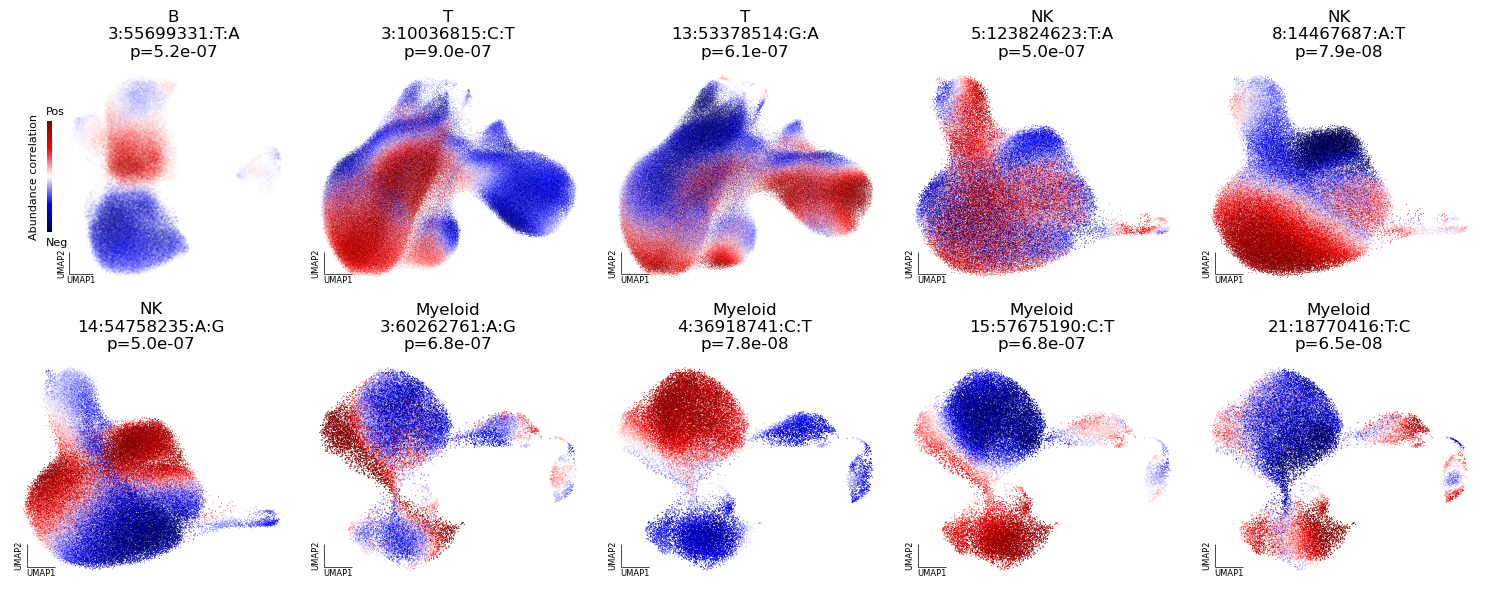

In [5]:
fig, axes = plt.subplots(2,5, figsize = (15,6), dpi = 100)

# Plot B suggestive phenotypes
d = cna.read("/data/srlab/lrumker/datasets/onek1k/pheno/B.h5ad")
d.obs['kept'] = np.repeat(False, d.obs.shape[0])
d.obs.loc[B_phenos.index,'kept'] = True
pp.umapprops['s'] = 0.4
for i, ax in enumerate(axes.reshape(-1,)[:1]):
    cbar_plot = ax.scatter(d.obsm['X_umap'][d.obs.kept,0], d.obsm['X_umap'][d.obs.kept,1],
                    c = B_phenos.iloc[:,i], cmap = "seismic", s = 0.001)
    ax.axis("off")
    cbar = plt.colorbar(cbar_plot, ticks = [], shrink=0.5, location='left', ax = ax, pad = 0.01)
    cbar.set_ticklabels([])
    cbar.outline.set_visible(False)
    ax.set_title("\n".join(B_phenos.columns[i].split("_"))+"\n"+\
                'p='+'{:.1e}'.format(sugg_loci.loc[B_phenos.columns[i],'P']))
    
    x_min = np.min(d.obsm['X_umap'][d.obs.kept,0])
    y_min = np.min(d.obsm['X_umap'][d.obs.kept,1])
    ax.text(x_min+0.45*x_min,
            y_min*0.18,'Abundance correlation', fontsize=8, rotation = 90)
    ax.text(x_min+0.25*x_min,y_min*0.34,'Neg', fontsize=8)
    ax.text(x_min+0.25*x_min,y_min*-2.4,'Pos', fontsize=8)
    add_umap_axes(ax, umap_axis_length = 0.1, umap_axis_offset = 0.06, 
              axis_lw = 0.5, umap_text_size = 6)

# Plot T suggestive phenotypes
pp.umapprops['s'] = 0.1
for i, ax in enumerate(axes.reshape(-1,)[1:3]):
    pp.scatter_random(d_T.obsm['X_umap'][d_T.obs.kept,0], d_T.obsm['X_umap'][d_T.obs.kept,1],
                    c = T_phenos.iloc[:,i], ax = ax, cmap = "seismic")
    ax.axis("off")
    ax.set_title("\n".join(T_phenos.columns[i].split("_"))+"\n"+\
                'p='+'{:.1e}'.format(sugg_loci.loc[T_phenos.columns[i],'P']))
    add_umap_axes(ax, umap_axis_length = 0.1, umap_axis_offset = 0.06, 
              axis_lw = 0.5, umap_text_size = 6)

# Plot NK suggestive phenotypes
d = cna.read("/data/srlab/lrumker/datasets/onek1k/pheno/NK.h5ad")
d.obs['kept'] = np.repeat(False, d.obs.shape[0])
d.obs.loc[NK_phenos.index,'kept'] = True
pp.umapprops['s'] = 0.4
for i, ax in enumerate(axes.reshape(-1,)[3:6]):
    pp.scatter_random(d.obsm['X_umap'][d.obs.kept,0], d.obsm['X_umap'][d.obs.kept,1],
                    c = NK_phenos.iloc[:,i], ax = ax, cmap = "seismic")
    ax.axis("off")
    ax.set_title("\n".join(NK_phenos.columns[i].split("_"))+"\n"+\
                'p='+'{:.1e}'.format(sugg_loci.loc[NK_phenos.columns[i],'P']))
    add_umap_axes(ax, umap_axis_length = 0.1, umap_axis_offset = 0.06, 
              axis_lw = 0.5, umap_text_size = 6)
    
# Plot Myeloid suggestive phenotypes
d = cna.read("/data/srlab/lrumker/datasets/onek1k/pheno/Myeloid.h5ad")
d.obs['kept'] = np.repeat(False, d.obs.shape[0])
d.obs.loc[M_phenos.index,'kept'] = True
pp.umapprops['s'] = 0.6
for i, ax in enumerate(axes.reshape(-1,)[6:10]):
    pp.scatter_random(d.obsm['X_umap'][d.obs.kept,0], d.obsm['X_umap'][d.obs.kept,1],
                    c = M_phenos.iloc[:,i], ax = ax, cmap = "seismic")
    ax.axis("off")
    ax.set_title("\n".join(M_phenos.columns[i].split("_"))+"\n"+\
                'p='+'{:.1e}'.format(sugg_loci.loc[M_phenos.columns[i],'P']))
    add_umap_axes(ax, umap_axis_length = 0.1, umap_axis_offset = 0.06, 
              axis_lw = 0.5, umap_text_size = 6)
    
plt.tight_layout()
plt.savefig(fig_dir+"suppfig.sugg_snps.png", bbox_inches='tight')
plt.show()

## Sample-level phenotypes

In [6]:
# Load suggestive loci phenotypes
NK_phenos = pd.read_table(res_folder+"gwas_NK/sugg_spheno.tsv", index_col=0)
NK_phenos.columns = ["NK_"+NK_phenos.columns[i] for i in np.arange(NK_phenos.shape[1])]

M_phenos = pd.read_table(res_folder+"gwas_Myeloid/sugg_spheno.tsv", index_col=0)
M_phenos.columns = ["Myeloid_"+M_phenos.columns[i] for i in np.arange(M_phenos.shape[1])]

T_phenos = pd.read_table(res_folder+"gwas_T/sugg_spheno.tsv", index_col=0)
T_phenos.columns = ["T_"+T_phenos.columns[i] for i in np.arange(T_phenos.shape[1])]

B_phenos = pd.read_table(res_folder+"gwas_B/sugg_spheno.tsv", index_col=0)
B_phenos.columns = ["B_"+B_phenos.columns[i] for i in np.arange(B_phenos.shape[1])]

In [7]:
def plot_trait_cors(phenos, ax, celltype):
    snp_names = [phenos.columns[i].split("_")[1] for i in np.arange(phenos.shape[1])]
    vals = phenos.corr()**2
    mask = np.triu(vals, k=1)
    vals = np.ma.array(vals, mask=mask)

    im = ax.imshow(vals, cmap="seismic")
    ax.set_xticks(np.arange(len(snp_names)))
    ax.set_xticklabels(snp_names)
    ax.set_yticks(np.arange(len(snp_names)))
    ax.set_yticklabels(snp_names)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    for i in range(len(snp_names)):
        for j in range(len(snp_names)):
            text = ax.text(j, i, np.around(vals[i, j],2),
                           ha="center", va="center", color="w")
    ax.set_title(celltype+"\nPearson's r-squared between traits")

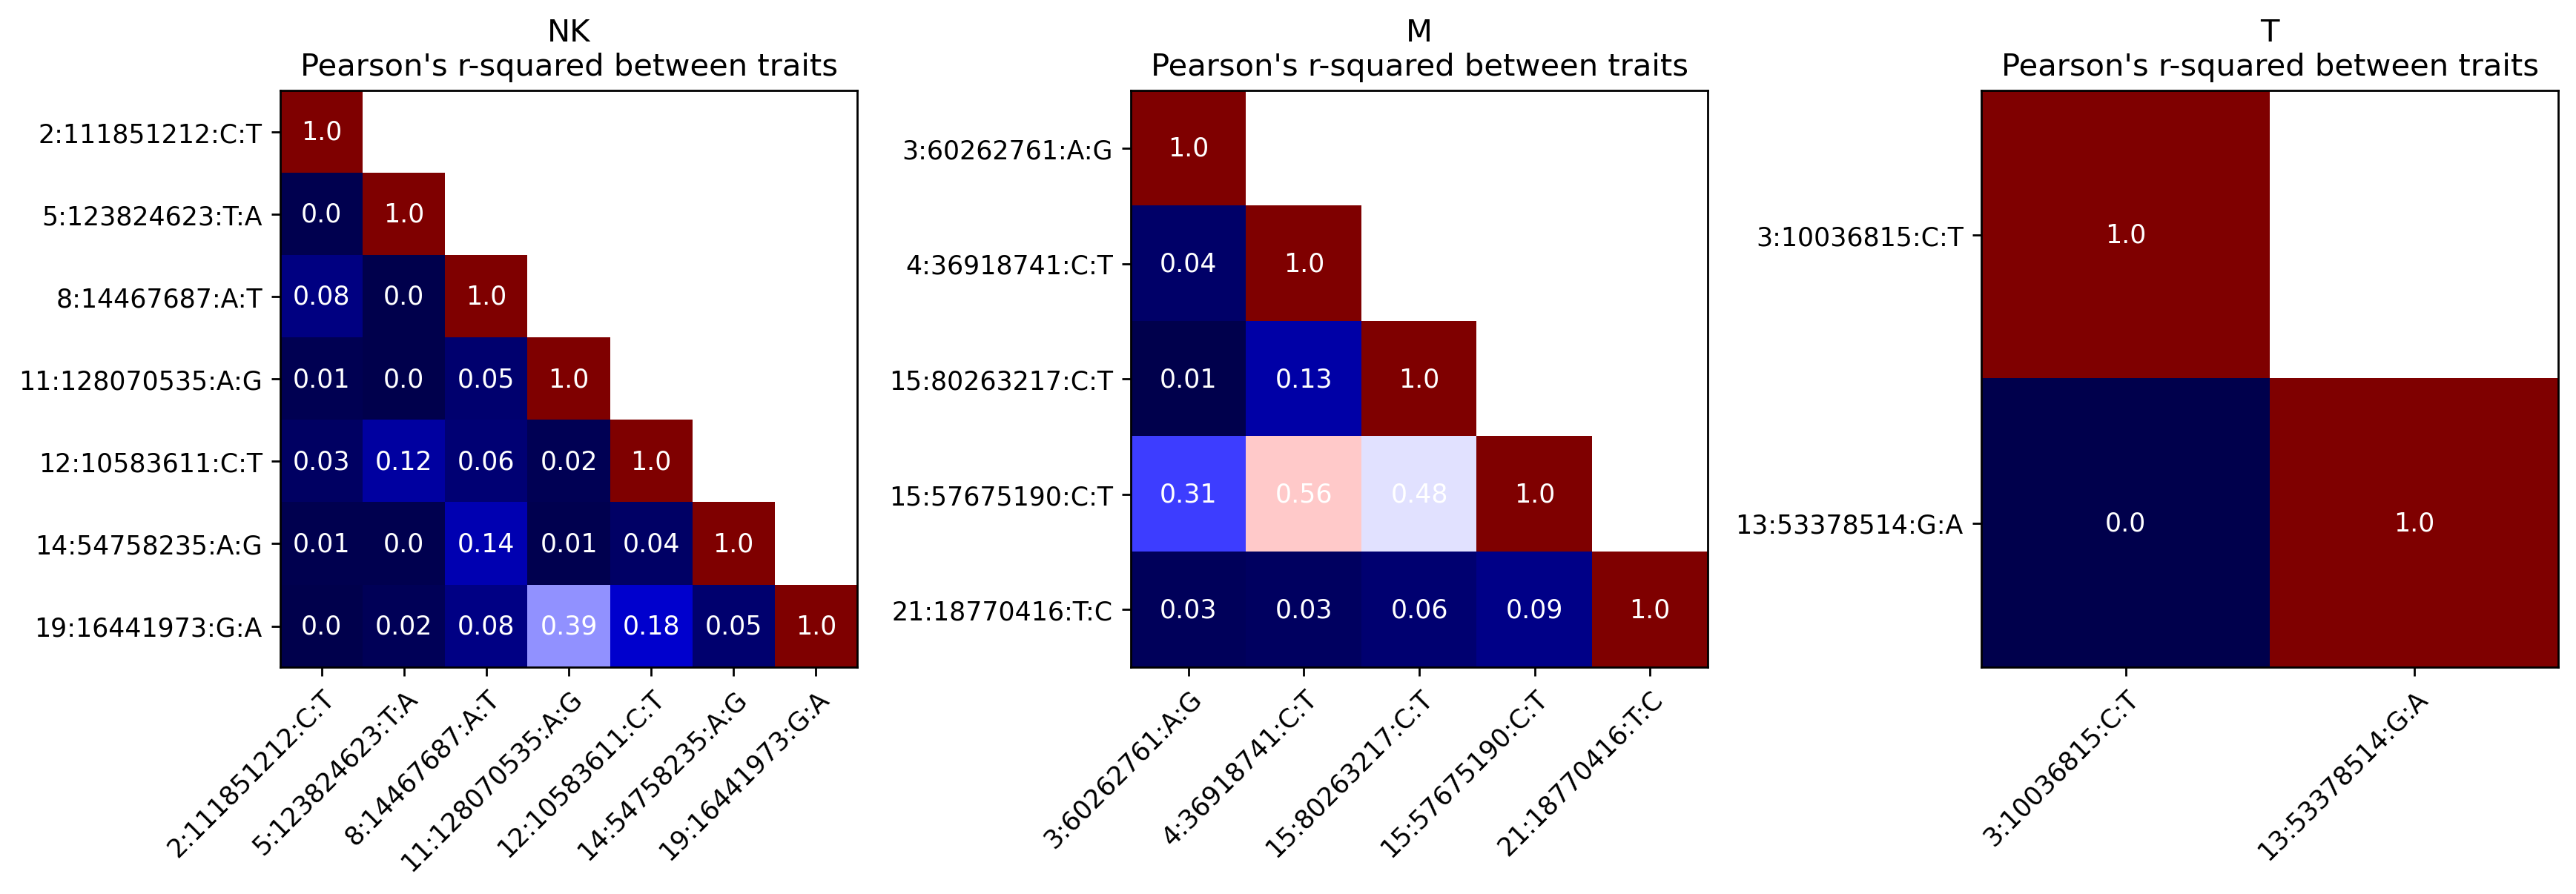

In [8]:
fig, axs = plt.subplots(1,3, figsize=(14,5), dpi = 250)
plot_trait_cors(NK_phenos, axs[0], "NK")
plot_trait_cors(M_phenos, axs[1], "M")
plot_trait_cors(T_phenos, axs[2], "T")
plt.tight_layout()
plt.savefig(fig_dir+"suppfig.trait_corrs.png", bbox_inches='tight')
plt.show()